In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
# Carregar os dados

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

# Carregar os dados
gluon_df = pd.read_csv('/content/drive/MyDrive/ML/Seminario/g_jets.csv', header=None, delimiter='\s+')
quark_df = pd.read_csv('/content/drive/MyDrive/ML/Seminario/q_jets.csv', header=None, delimiter='\s+')
top_df = pd.read_csv('/content/drive/MyDrive/ML/Seminario/t_jets.csv', header=None, delimiter='\s+')


In [4]:
# Função para reshape
def reshape_data(df):
    return df.values.reshape(-1, 30, 4)


data_g = reshape_data(gluon_df)
data_q = reshape_data(quark_df)
data_t = reshape_data(top_df)

# Combinar dados e criar rótulos
data = np.concatenate((data_g, data_t, data_q), axis=0)
labels = np.concatenate((
    np.zeros(len(data_g)),  # 0 para gluons
    np.ones(len(data_t)),   # 1 para tops
    np.full(len(data_q), 2) # 2 para quarks
))

# Extrair coordenadas eta_rel, phi_rel, pt_rel e mask
eta = data[:, :, 0]
phi = data[:, :, 1]
pt = data[:, :, 2]
mask = data[:, :, 3]

# Função para calcular a diferença mínima de ângulo considerando a periodicidade de phi
def delta_phi(phi1, phi2):
    dphi = phi1 - phi2
    dphi = np.mod(dphi + np.pi, 2 * np.pi) - np.pi
    return dphi

# Calcular R_ij
def calculate_Rij(eta, phi):
    num_particles = eta.shape[1]
    R_ij = np.zeros((eta.shape[0], num_particles, num_particles))

    for i in range(num_particles):
        for j in range(num_particles):
            delta_eta = eta[:, i] - eta[:, j]
            delta_phi_ij = delta_phi(phi[:, i], phi[:, j])
            R_ij[:, i, j] = np.sqrt(delta_eta**2 + delta_phi_ij**2)

    return R_ij

R_ij = calculate_Rij(eta, phi)

# Reshape das características originais para [N, 30 * 4]
features_jet = data.reshape(data.shape[0], -1)

# Concatenar todas as características com os valores exatos de R_ij
features = np.concatenate((features_jet, R_ij.reshape(R_ij.shape[0], -1)), axis=1)

In [5]:
# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)


In [6]:
# Pré-processamento dos dados
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Construir o modelo de rede neural
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),  # Adicionando dropout para reduzir overfitting
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

# Compilar o modelo com uma taxa de aprendizado menor
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Treinar o modelo por mais épocas
history = model.fit(X_train_normalized, y_train_encoded, epochs=50, batch_size=64, validation_split=0.2, verbose=1)

# Avaliar o modelo
test_loss, test_accuracy = model.evaluate(X_test_normalized, y_test_encoded)
print('Test Accuracy:', test_accuracy)

# Previsões
y_pred = np.argmax(model.predict(X_test_normalized), axis=-1)


Epoch 1/50
5259/5259 [==============================] - 20s 3ms/step - loss: 0.6796 - accuracy: 0.7166 - val_loss: 0.6325 - val_accuracy: 0.7384
Epoch 2/50
5259/5259 [==============================] - 15s 3ms/step - loss: 0.6403 - accuracy: 0.7392 - val_loss: 0.6230 - val_accuracy: 0.7461
Epoch 3/50
5259/5259 [==============================] - 16s 3ms/step - loss: 0.6306 - accuracy: 0.7448 - val_loss: 0.6159 - val_accuracy: 0.7482
Epoch 4/50
5259/5259 [==============================] - 16s 3ms/step - loss: 0.6259 - accuracy: 0.7471 - val_loss: 0.6190 - val_accuracy: 0.7480
Epoch 5/50
5259/5259 [==============================] - 15s 3ms/step - loss: 0.6207 - accuracy: 0.7490 - val_loss: 0.6101 - val_accuracy: 0.7508
Epoch 6/50
5259/5259 [==============================] - 16s 3ms/step - loss: 0.6175 - accuracy: 0.7510 - val_loss: 0.6094 - val_accuracy: 0.7507
Epoch 7/50
5259/5259 [==============================] - 16s 3ms/step - loss: 0.6145 - accuracy: 0.7524 - val_loss: 0.6075 - val_ac

In [7]:
# Métricas de avaliação
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print("Matriz de Confusão:")
print(conf_matrix)


# Converter label_encoder.classes_ para uma lista de strings
class_names = ['Gluon', 'Top', 'Quark']

# Exibir o relatório de classificação com as classes corretas
print("\nRelatório de Classificação:")
report_str = classification_report(y_test_encoded, y_pred, target_names=class_names)
print(report_str)


Matriz de Confusão:
[[25627  5034  4822]
 [ 3408 30770  1454]
 [ 6503  3177 24381]]

Relatório de Classificação:
              precision    recall  f1-score   support

       Gluon       0.72      0.72      0.72     35483
         Top       0.79      0.86      0.82     35632
       Quark       0.80      0.72      0.75     34061

    accuracy                           0.77    105176
   macro avg       0.77      0.77      0.77    105176
weighted avg       0.77      0.77      0.77    105176



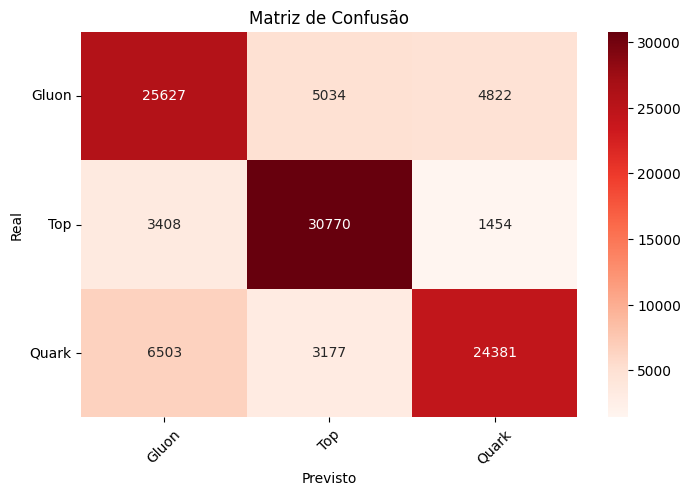

In [8]:
# Plot da matriz de confusão com rótulos
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')

# Definir rótulos manualmente
tick_labels = ['Gluon', 'Top', 'Quark']

# Adicionar rótulos para as classes
plt.xticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=45)
plt.yticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=0)

plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')

plt.show()

<Figure size 1000x600 with 0 Axes>

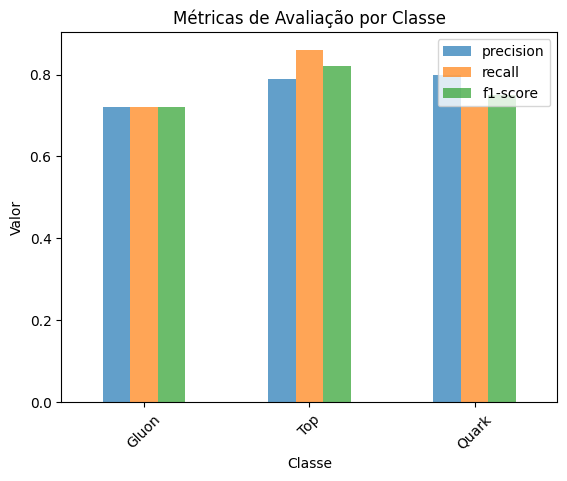

In [9]:
# Métricas para cada classe
class_metrics = {}

# Obter o relatório de classificação como uma lista de linhas
report_lines = classification_report(y_test_encoded, y_pred, target_names=class_names).split('\n')

# Iterar sobre as linhas do relatório (ignorando a primeira e última linhas)
for line in report_lines[2:-5]:
    # Dividir a linha em palavras
    words = line.split()
    # Extrair o nome da classe
    class_name = words[0]
    # Extrair as métricas de precisão, recall e f1-score
    precision = float(words[1])
    recall = float(words[2])
    f1_score = float(words[3])
    # Armazenar as métricas em um dicionário
    class_metrics[class_name] = {'precision': precision, 'recall': recall, 'f1-score': f1_score}

# Plotar as métricas de precisão, recall e f1-score
plt.figure(figsize=(10, 6))
metrics_df = pd.DataFrame.from_dict(class_metrics, orient='index')
metrics_df.plot(kind='bar', alpha=0.7)
plt.title('Métricas de Avaliação por Classe')
plt.xlabel('Classe')
plt.ylabel('Valor')
plt.xticks(ticks=[0, 1, 2], labels=['Gluon', 'Top', 'Quark'], rotation=45)
plt.legend(loc='upper right')
plt.show()

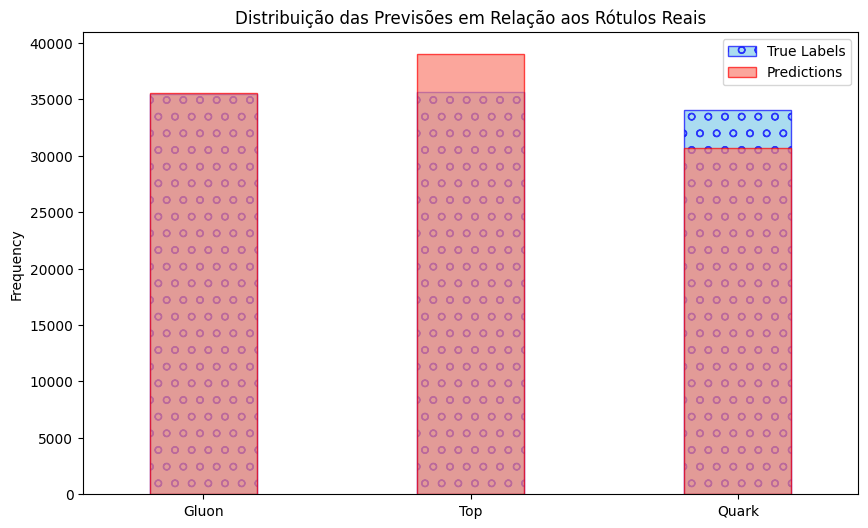

In [10]:
# Plotar gráfico da distribuição das previsões em relação aos rótulos reais
true_counts = pd.Series(y_test_encoded).value_counts().sort_index()
pred_counts = pd.Series(y_pred).value_counts().sort_index()

plt.figure(figsize=(10, 6))
true_counts.plot(kind='bar', color='skyblue', alpha=0.7, label='True Labels', hatch='o', edgecolor='blue', width=0.4)
pred_counts.plot(kind='bar', color='salmon', alpha=0.7, label='Predictions', edgecolor='red', width=0.4)

plt.title('Distribuição das Previsões em Relação aos Rótulos Reais')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1, 2], labels=['Gluon', 'Top', 'Quark'], rotation=0)
plt.legend()
plt.show()